# 2.C: Include more complexity to the model

Includes background process, time offset, and time resolution

In [1]:
# Import modules needed for this tutorial
from trisep.LifetimeExperiment import LifetimeExperiment, SimulatedLifetimeExperiment
from trisep.MarkovChain import MarkovChain
import numpy as np
from scipy import stats
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background') # only include this if you use a dark background for Jupyter Lab

from iminuit import Minuit

## Compare data from the real experiment and from the simulation of a perfect setup

Make a histogram of lifetimes

In [2]:
# real experiment

lifetime_experiment = LifetimeExperiment()

lifetime_experiment.set_counting_time(10)  # specified in seconds: You will have to wait that long to get the result!
counting_time = lifetime_experiment.get_counting_time()  # read back the time to make sure it was set correctly

lifetime_experiment.start()
lab_times = lifetime_experiment.get_times()

# simulation of perfect experiment

sim_experiment = SimulatedLifetimeExperiment(isotope_lifetime=0.03)
sim_experiment.set_counting_time(counting_time)

sim_experiment.start()
sim_times = sim_experiment.get_times()

Lab lifetime experiment built. Default counting time is 10.0 seconds.
Please wait 10 seconds...
Simulated lifetime experiment built. Counting time = 10.0 Time resolution = 0.0 Time offset= 0.0 Background fraction = 0.0


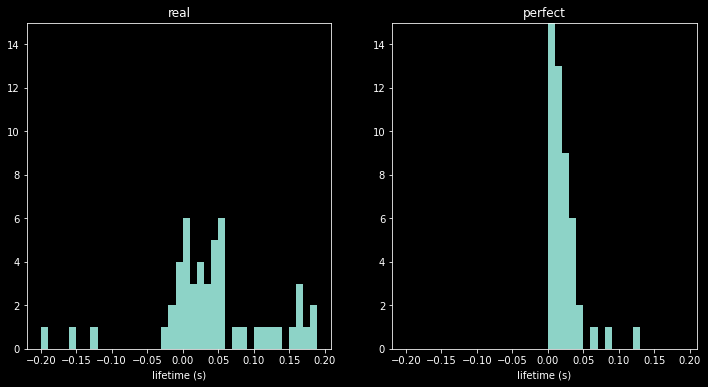

In [3]:
# compare histograms

fig, axes = plt.subplots(1,2,figsize=(12, 6))

for axis,times,title in zip(axes,[lab_times,sim_times],['real','perfect']):
    axis.hist(times,bins=np.arange(-0.2,0.2,0.01))
    axis.set_title(title)
    axis.set_ylim(0.,15.*counting_time/10.)
    axis.set_xlabel('lifetime (s)')
    
plt.show()

In [4]:
# calculate likelihood of observing real data assuming perfect setup



## Additional complexity:
 - some of the times reported are due to a background process whose time distribution is uniform
 - the lifetime is measured by the difference in two clocks which may have a time offset
 - the device has finite time resolution

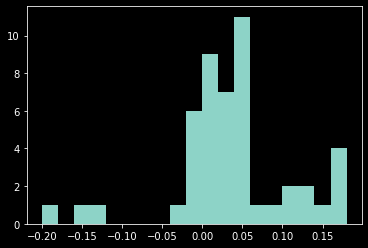

In [5]:
# compare model to real data to model

bin_width = 0.02

plt.hist(lab_times,bins=np.arange(-0.2,0.2,bin_width))

# ADD CODE to overlay the model pdf
# USE the get_pdf(time) method of the sim_experiment object


plt.show()

Simulated lifetime experiment built. Counting time = 10.0 Time resolution = 0.0 Time offset= 0.0 Background fraction = 0.0
Simulated lifetime experiment built. Counting time = 10.0 Time resolution = 0.0 Time offset= 0.0 Background fraction = 0.0
Simulated lifetime experiment built. Counting time = 10.0 Time resolution = 0.0 Time offset= 0.0 Background fraction = 0.0


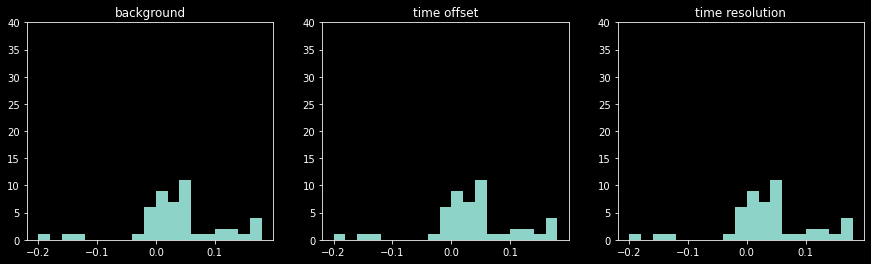

In [6]:
# now add the additional elements

fig, axes = plt.subplots(1,3,figsize=(15, 4))

for element,axis in enumerate(axes):
    full_model = SimulatedLifetimeExperiment(isotope_lifetime=0.03)
    
    if element == 0:
        full_model.set_background_fraction(0.2)
        axis.set_title('background')
    elif element == 1:
        full_model.set_time_offset(-0.05)
        axis.set_title('time offset')
    elif element == 2:
        full_model.set_time_resolution(0.01)
        axis.set_title('time resolution')
        
# ADD CODE to overlay the model pdf
# USE the get_pdf(time) method of the full_model object

    axis.hist(lab_times,bins=np.arange(-0.2,0.2,bin_width))
    axis.set_ylim(0.,40.*counting_time/10.)
    
plt.show()

In [7]:
# This time we have no control experiments to give us more information about the additional parameters
# The lifetime distribution will be used to estimate all of these

# Find point estimnates and approximate intervals with minuit

def get_full_neg_log_likelihood(tau,bf,t_off,t_sig):
    full_model.set_isotope_lifetime(tau)
    full_model.set_background_fraction(bf)
    full_model.set_time_offset(t_off)
    full_model.set_time_resolution(t_sig)
    return -1.*full_model.get_log_likelihood(lab_times)

get_full_neg_log_likelihood.errordef = Minuit.LIKELIHOOD

m = Minuit(get_full_neg_log_likelihood, tau=0.03, bf=0.1, t_off=0., t_sig=0.01)
m.limits['tau'] = (0., None)
m.limits['bf'] = (0., 1.)
m.limits['t_off'] = (-0.1,0.1)
m.limits['t_sig'] = (0., 0.5)

m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -71.36                     │              Nfcn = 143              │
│ EDM = 3.29e-05 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ tau   │   0.084   │   0.027   │            │            │    0    │         │       │
│ 1 │ bf    │   0.15    │   0.08    │            │            │    0    │    1    │       │
│ 2 │ t_off │  -0.015   │   0.006   │            │            │  -0.1   │   0.1   │       │
│ 3 │ t_sig │   0.007   │   0.005   │            │            │    0    │   0.5   │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │       tau        bf     t_off     t_sig │
├───────┼─────────────────────────────────────────┤
│   tau │  0.000754  -0.00067 -8.55e-05 -4.95e-05 │
│    bf │  -0.00067   0.00683  6.46e-05  1.81e-05 │
│ t_off │ -8.55e-05  6.46e-05  3.76e-05  2.11e-05 │
│ t_sig │ -4.95e-05  1.81e-05  2.11e-05  2.67e-05 │
└───────┴─────────────────────────────────────────┘

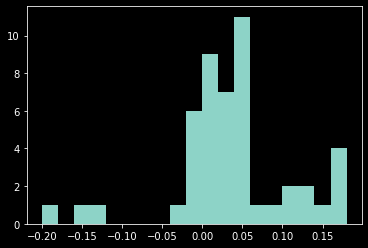

In [8]:
# Compare distribution of lab_times with optimized full_model pdf

bin_width = 0.02

plt.hist(lab_times,bins=np.arange(-0.2,0.2,bin_width))

# ADD CODE to overlay the model pdf
# USE the get_pdf(time) method of the full_model object

plt.show()

Error: Time resolution must be between 0. and 0.2
Error: Time resolution must be between 0. and 0.2
Error: Time resolution must be between 0. and 0.2
Error: Time resolution must be between 0. and 0.2
Error: Time resolution must be between 0. and 0.2
Error: Time resolution must be between 0. and 0.2
Error: Time resolution must be between 0. and 0.2
Error: Time resolution must be between 0. and 0.2
Error: Time resolution must be between 0. and 0.2
Error: Time resolution must be between 0. and 0.2
Error: Time resolution must be between 0. and 0.2
Error: Time resolution must be between 0. and 0.2
Error: Time resolution must be between 0. and 0.2
Error: Time resolution must be between 0. and 0.2
Error: Time resolution must be between 0. and 0.2
Error: Time resolution must be between 0. and 0.2
Error: Time resolution must be between 0. and 0.2
Error: Time resolution must be between 0. and 0.2
Error: Time resolution must be between 0. and 0.2
Error: Time resolution must be between 0. and 0.2


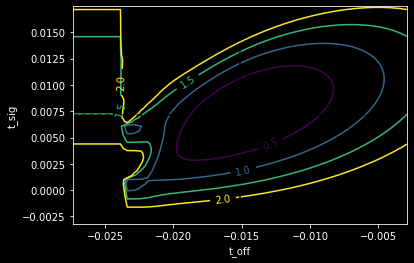

In [9]:
# minuit provides methods to show 2D contours of neg log likelihood around minimum (keeping other parameters fixed)
# Even if priors are uniform, this is NOT equivalent to the marginalized posterior. Be careful in interpretting such contours.
# Recommendation: Use the MCMC approach to show the marginalized posterior.

m.draw_contour('t_off','t_sig');

In [10]:
# Often, an adhoc approach to reduce dimensionality of the likelihood function is to optimize over
# the other variables. Frequentist intervals constructed in this way do not necessarily have good coverage.

# Warning: this can take time to complete and may fail when sample size is small.
# m.draw_mncontour('t_off','t_sig');

In [14]:
# Explore the posterior using MCMC

def logP(params):
    tau = params['tau']
    bf = params['bf']
    t_off = params['t_off']
    t_sig = params['t_sig']

    neg_log_likelihood = get_full_neg_log_likelihood(tau,bf,t_off,t_sig)

    # assuming uniform prior:
    return -1.*neg_log_likelihood

parameters = [
    {'name':'tau','start':0.03,'step':0.001,'min':0.001,'max':1.},
    {'name':'bf','start':0.06,'step':0.05,'min':0.0,'max':0.5},
    {'name':'t_off','start':0.,'step':0.005,'min':-0.2,'max':0.2},
    {'name':'t_sig','start':0.02,'step':0.005,'min':0.,'max':0.1}
]
mcmc = MarkovChain(parameters, logP)
chain = mcmc.get_chain(100000)

 10%|█         | 10018/100000 [00:57<08:36, 174.36it/s]


KeyboardInterrupt: 

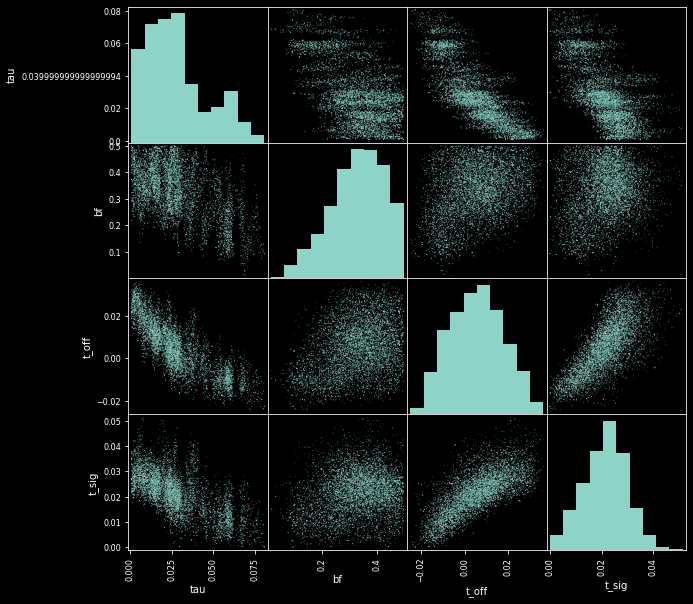

In [12]:
df = pd.DataFrame(chain)
pd.plotting.scatter_matrix(df,s=3,figsize=[10,10]);

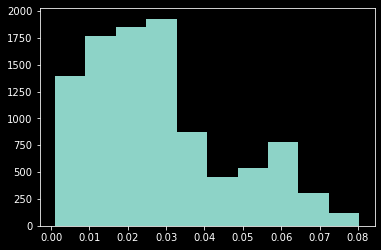

TypeError: type ellipsis doesn't define __round__ method

In [15]:
# Marginalize to 1D posterior distribution for lifetime and find 90% credible interval

tau_list = [dict['tau'] for dict in chain]
plt.hist(tau_list)
plt.show()

tau_low = ...
tau_high = ...

print('90% credible interval for lifetime: [',round(tau_low,3),',',round(tau_high,3),']')